In [3]:
import pydicom
from utils import *

from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
v1_df = pd.read_csv('/home/workspace2/LUS/Dataset/csv_files/version1_v1.csv', index_col=0)

print(len(v1_df))

388


In [4]:
v1_df.head()

,PatientID,Data_idx,StudyDate,Data_type,A-line,B-line,Confluent B-line,Consolidation,Pleural effusion,Lung sliding,Lung Ultrasound Score,study_id
0,24965778,2,20230614,video,NaN,24_32,NaN,NaN,NaN,NaN,1,24965778_2
1,24965778,3,20230614,video,NaN,24_27,NaN,NaN,NaN,NaN,1,24965778_3
2,24965778,4,20230614,video,NaN,NaN,NaN,2_18,NaN,NaN,3_c,24965778_4
3,24965778,5,20230614,video,NaN,NaN,NaN,NaN,1_54,NaN,3_e,24965778_5
4,24965778,6,20230614,video,15_60,NaN,NaN,NaN,NaN,NaN,0,24965778_6


In [5]:
def create_path(row):
    root_path = "/home/workspace2/LUS/Dataset/processed_dcm_dataset"
    patient_id = int(row['PatientID'])
    data_idx = f"{row['Data_idx']:05d}"
    return f"{root_path}/{patient_id}/{data_idx}.dcm"

In [6]:
v1_df['dcm_path'] = v1_df.apply(create_path, axis=1)
v1_df.head()

,PatientID,Data_idx,StudyDate,Data_type,A-line,B-line,Confluent B-line,Consolidation,Pleural effusion,Lung sliding,Lung Ultrasound Score,study_id,dcm_path
0,24965778,2,20230614,video,NaN,24_32,NaN,NaN,NaN,NaN,1,24965778_2,/home/workspace2/LUS/Dataset/processed_dcm_dat...
1,24965778,3,20230614,video,NaN,24_27,NaN,NaN,NaN,NaN,1,24965778_3,/home/workspace2/LUS/Dataset/processed_dcm_dat...
2,24965778,4,20230614,video,NaN,NaN,NaN,2_18,NaN,NaN,3_c,24965778_4,/home/workspace2/LUS/Dataset/processed_dcm_dat...
3,24965778,5,20230614,video,NaN,NaN,NaN,NaN,1_54,NaN,3_e,24965778_5,/home/workspace2/LUS/Dataset/processed_dcm_dat...
4,24965778,6,20230614,video,15_60,NaN,NaN,NaN,NaN,NaN,0,24965778_6,/home/workspace2/LUS/Dataset/processed_dcm_dat...


In [7]:
sample_paths = [i for i in v1_df.dcm_path]
slice1 = [pydicom.read_file(sample_path, force=True) for sample_path in sample_paths]

Total dicom : 388
image_dicom : 39
video_dicom : 349


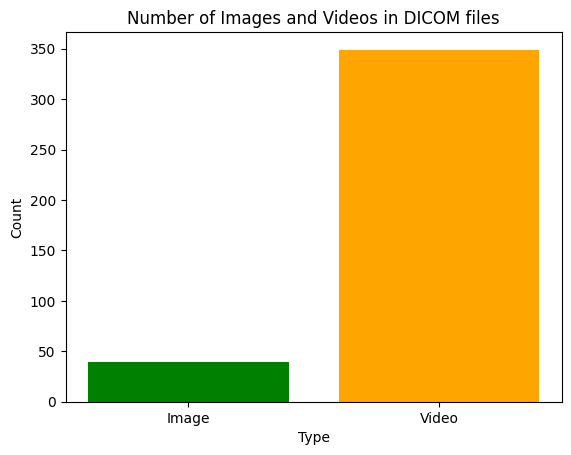

In [8]:
image_count = 0
video_count = 0

for slice in slice1:
    # if 'PixelData' in slice and slice.PixelData is not None:
    if (0x0028, 0x0008) not in slice:
        image_count += 1
    else:
        # pixel_array가 4인 경우, 동영상으로 간주
        video_count += 1

print(f"Total dicom : {image_count + video_count}")
print(f"image_dicom : {image_count }")
print(f"video_dicom : {video_count}")
data = [image_count, video_count]
labels = ['Image', 'Video']
colors = ['green', 'orange']

plt.bar(labels, data, color=colors)
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Number of Images and Videos in DICOM files')
plt.show()

## image / video shape 확인
- image 
    - original shape : (924, 1232, 3)
    - cropped shape : (771, 988, 3)
    - crop pixel index : (160, 106, 1148, 877) >> (xmin, ymin, xmax, ymax)
- video
    - number of frame : 39, 61, 62, 152
    - cine rate : 30

In [9]:
# Image data Size check
image_size = []
xmin_list = []
ymin_list = []
xmax_list = []
ymax_list = []
no = []

for idx, slice in enumerate(slice1):
    # if 'PixelData' in slice and slice.PixelData is not None:
    if (0x0028, 0x0008) not in slice:
        image_size.append(slice.pixel_array.shape)
    if (0x0018, 0x6011) in slice:

        # print(slice[(0x018, 0x6011)].value[0][(0x018, 0x6018)].value)
        xmin_list.append(slice[(0x018, 0x6011)].value[0][(0x018, 0x6018)].value)
        ymin_list.append(slice[(0x018, 0x6011)].value[0][(0x018, 0x601a)].value)
        xmax_list.append(slice[(0x018, 0x6011)].value[0][(0x018, 0x601c)].value)
        ymax_list.append(slice[(0x018, 0x6011)].value[0][(0x018, 0x601e)].value)
    if (0x0018, 0x6011) not in slice:
        no.append(slice)
        print(idx)


In [10]:
# xmin, ymin, xmax, ymax 리스트들의 조합을 set으로 변환하여 유니크한 개수를 확인
unique_combinations = set(zip(xmin_list, ymin_list, xmax_list, ymax_list))
num_unique_combinations = len(unique_combinations)
print(set(image_size))
print(f"case_num: {num_unique_combinations}")
print(f"case: {unique_combinations}")

{(924, 1232, 3)}
case_num: 1
case: {(160, 106, 1148, 877)}


In [11]:
# video number_of_frame, cine_rate(fps) 
number_of_frame = []
cine_rate = []

# (0028, 0008) Number of Frames
# (0018, 0040) Cine Rate 

# print(video_ds[(0x0028, 0x0008)].value)
# print(video_ds[(0x0018, 0x0040)].value)

for slice in slice1:
    # if 'PixelData' in slice and slice.PixelData is not None:
    if (0x0028, 0x0008) in slice:
        # frame time
        number_of_frame.append(slice[(0x0028, 0x0008)].value)
        # cine rate
        cine_rate.append(slice[(0x0018, 0x0040)].value)

In [12]:
print(set(number_of_frame))
print(set(cine_rate))
print('-'*30)
from collections import Counter

frame_counts = Counter(number_of_frame)
# fps_counts = Counter(cine_rate)

# 결과 출력
counts = []
for element, count in frame_counts.items():
    counts.append(count)
    print(f"{element}: {count} 개")

unique_number_frame = [int(i) for i in list(set(number_of_frame))] 
video_all_times = [round(i/30, 3) for i in unique_number_frame]
print('unique_number_frame : ', unique_number_frame)
print('video_all_times :', video_all_times)
print(frame_counts)

{'152', '62', '39'}
{'30'}
------------------------------
62: 44 개
152: 304 개
39: 1 개
unique_number_frame :  [152, 62, 39]
video_all_times : [5.067, 2.067, 1.3]
Counter({'152': 304, '62': 44, '39': 1})


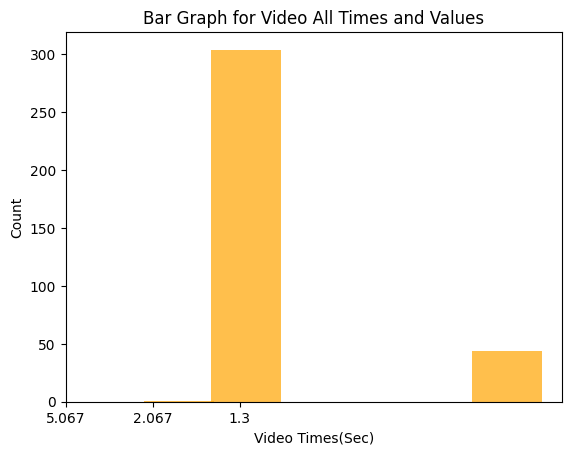

In [13]:
plt.bar(video_all_times, counts, color='orange', alpha=0.7, align='center')
plt.xlabel('Video Times(Sec)')
plt.ylabel('Count')
plt.title('Bar Graph for Video All Times and Values')

# x축 눈금과 레이블 설정 (실수형으로 변환)
plt.xticks(range(len(video_all_times)), video_all_times)

plt.show()

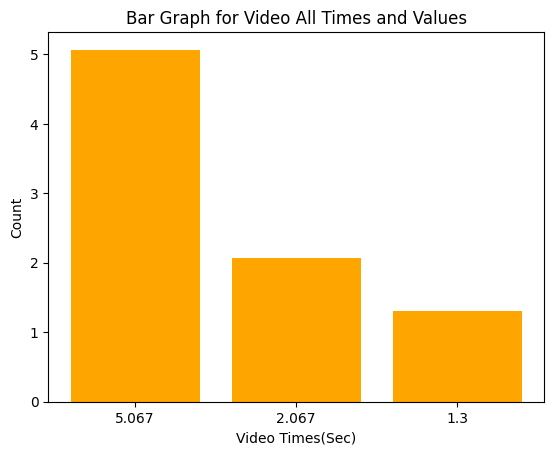

In [14]:
plt.bar(range(len(video_all_times)), video_all_times, color='orange')
plt.xlabel('Video Times(Sec)')
plt.ylabel('Count')
plt.title('Bar Graph for Video All Times and Values')

# x축 눈금과 레이블 설정 (실수형으로 변환)
plt.xticks(range(len(video_all_times)), video_all_times)

plt.show()

## dicom image crop

(152, 924, 1232, 3)

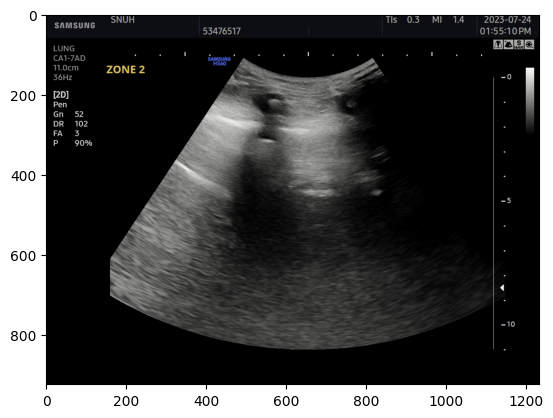

In [15]:
path = '/home/workspace2/LUS/Dataset/processed_dcm_dataset/53476517/00003.dcm'
ds = pydicom.read_file(path, force=True)

plt.imshow(ds.pixel_array[0])
ds.pixel_array.shape

In [17]:
img_ds_path = '/home/workspace2/LUS/Dataset/processed_dcm_dataset/39009687/00004.dcm'
video_ds_path = '/home/workspace2/LUS/Dataset/processed_dcm_dataset/39009687/00002.dcm'

img_ds = pydicom.read_file(img_ds_path, force=True)
video_ds = pydicom.read_file(video_ds_path, force=True)

In [18]:
print(img_ds.pixel_array.shape)
print(video_ds.pixel_array.shape)

(924, 1232, 3)
(62, 924, 1232, 3)


In [19]:
# (0028, 0008) Number of Frames
# (0018, 0040) Cine Rate 
# ds[(0x018, 0x6011)].value
print(video_ds[(0x0018, 0x1063)].value)
print(video_ds[(0x0018, 0x0040)].value)
video_ds

33.3333
30


/usr/local/lib/python3.8/site-packages/pydicom/valuerep.py:290: UserWarning: The value length (22) exceeds the maximum length of 16 allowed for VR SH.
  warnings.warn(msg)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 226
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Ultrasound Multi-frame Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.410.200001.101.11.601.1791001860.3.20230720163500435
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.410.200003.2020819.5.2.1
(0002, 0013) Implementation Version Name         SH: 'MAROTECH REGISTER 5.0'
(0002, 0016) Source Application Entity Title     AE: 'ACQ1_8054'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: Ultrasound Multi-frame Image Storage
(0008, 0018) SOP Instance UID             

In [20]:
xmin = img_ds[(0x018, 0x6011)].value[0][(0x018, 0x6018)].value
ymin = img_ds[(0x018, 0x6011)].value[0][(0x018, 0x601a)].value
xmax = img_ds[(0x018, 0x6011)].value[0][(0x018, 0x601c)].value
ymax = img_ds[(0x018, 0x6011)].value[0][(0x018, 0x601e)].value

print(xmin, ymin,xmax, ymax)

160 106 1148 877


(771, 988, 3)

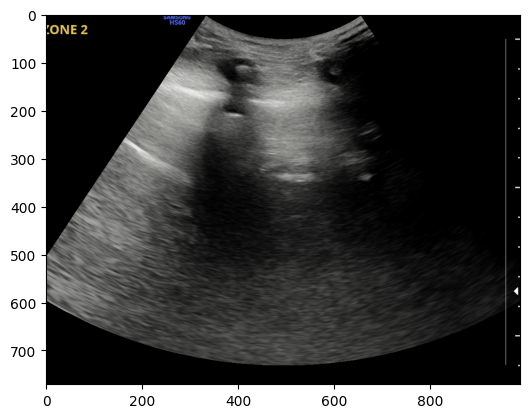

In [21]:
plt.imshow(ds.pixel_array[0][ymin:ymax, xmin:xmax])
ds.pixel_array[60][ymin:ymax, xmin:xmax].shape

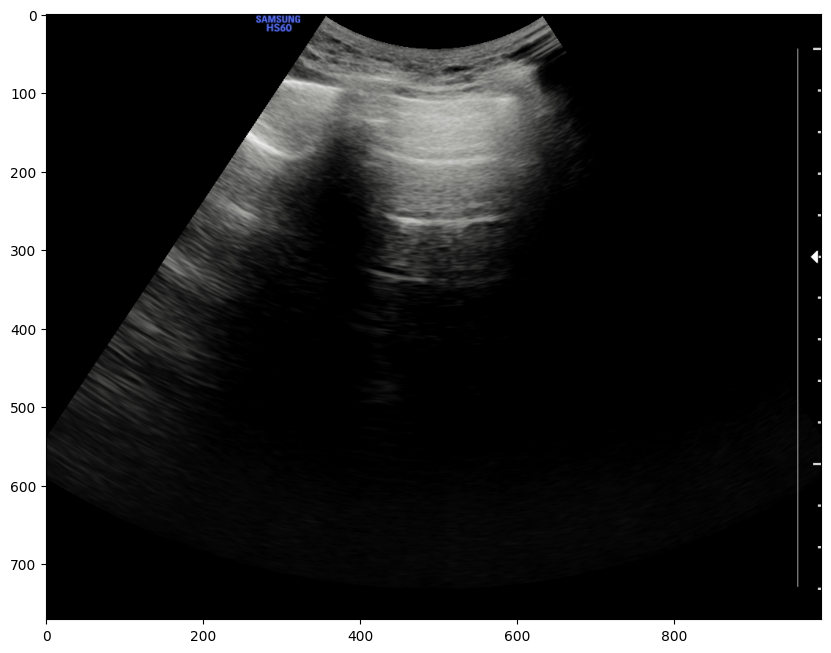

In [22]:
import matplotlib.pyplot as plt

cropped_array = img_ds.pixel_array[ymin:ymax, xmin:xmax]

plt.figure(figsize=(10, 10)) 
plt.imshow(cropped_array)

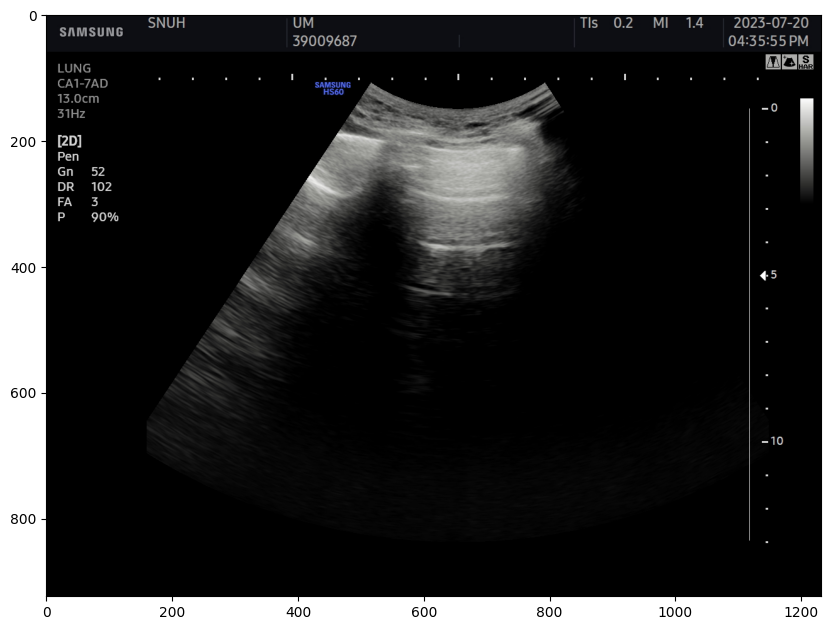

In [23]:
import matplotlib.pyplot as plt

# cropped_array = ds.pixel_array[0][ymin:ymax, xmin:xmax]
plt.figure(figsize=(10, 10)) 
plt.imshow(img_ds.pixel_array)

# 영상의학과 pneumothorax case 확인 

In [ ]:
path1 = '/home/work/kt060_DR-TB/LJH/MICU_LUS/Dataset/original_dataset/pneumothorax_case'

paths1 = load_file_path(path1, DCM_EXTENSION, all_sub_folders=True)

slices = [pydicom.read_file(sample_path, force=True) for sample_path in paths1]

In [ ]:
print(len(paths1))

In [ ]:
slices_1 = [idx for idx in slices if (0x018, 0x6011) in idx]

In [ ]:
image_count = 0
video_count = 0

for slice in slices_1:
    # if 'PixelData' in slice and slice.PixelData is not None:
    if (0x0028, 0x0008) not in slice:
        image_count += 1
    else:
        # pixel_array가 4인 경우, 동영상으로 간주
        video_count += 1

data = [image_count, video_count]
labels = ['Image', 'Video']
colors = ['green', 'orange']

print(f"image 갯수 : {data[0]}")
print(f"video 갯수 : {data[1]}")
plt.bar(labels, data, color=colors)
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Number of Images and Videos in DICOM files')
plt.show()

In [ ]:
# video number_of_frame, cine_rate(fps) 
number_of_frame = []
cine_rate = []

# (0028, 0008) Number of Frames
# (0018, 0040) Cine Rate 

# print(video_ds[(0x0028, 0x0008)].value)
# print(video_ds[(0x0018, 0x0040)].value)

for slice in slices:
    # if 'PixelData' in slice and slice.PixelData is not None:
    if (0x0028, 0x0008) in slice:
        # frame time
        number_of_frame.append(slice[(0x0028, 0x0008)].value)
        # cine rate
        cine_rate.append(slice[(0x0018, 0x0040)].value)

In [ ]:
print(set(number_of_frame))
print(set(cine_rate))
print('-'*30)
from collections import Counter

frame_counts = Counter(number_of_frame)
# fps_counts = Counter(cine_rate)

# 결과 출력
for element, count in frame_counts.items():
    print(f"{element}: {count} 개")

unique_number_frame = [int(i) for i in list(set(number_of_frame))] 
video_all_times = [round(i/30, 3) for i in unique_number_frame]
print('unique_number_frame : ', unique_number_frame)
print('video_all_times :', video_all_times)
print(frame_counts)

In [ ]:
plt.bar(range(len(video_all_times)), video_all_times, color='orange')
plt.xlabel('Video Times(Sec)')
plt.ylabel('Count')
plt.title('Bar Graph for Video All Times and Values')

# x축 눈금과 레이블 설정 (실수형으로 변환)
plt.xticks(range(len(video_all_times)), video_all_times)

plt.show()